# Position Reconstruction for XeBRA - Neural Networks - Measurements Analysis

**Status:** August 2019

Position reconstruction for XeBRA using a feedforward neural network with Keras.

In [1]:
## Imports:

!python -V

import os
import sys
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec
from matplotlib.image import NonUniformImage
from matplotlib.patches import Rectangle
%matplotlib inline
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

import pandas as pd
print('pandas version = '+str(pd.__version__))
import numpy as np
import math

import keras
print('keras version = '+str(keras.__version__))
from keras.models import Sequential,Model,load_model
from keras.layers import Input,Dense,Dropout,Activation
from keras.optimizers import SGD,Adam
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split

from ann_visualizer.visualize import ann_viz

from scipy.interpolate import griddata

Python 3.7.3
pandas version = 0.24.2


Using TensorFlow backend.


keras version = 2.2.4


## General Definitions and Parameters

In [2]:
#### General function definitions:

def f_polar_R(cartesian_x, cartesian_y):
    return np.sqrt(cartesian_x * cartesian_x + cartesian_y * cartesian_y)

def f_polar_Phi(cartesian_x, cartesian_y):
    return np.arctan2(cartesian_y, cartesian_x)

def f_distance(x_a, y_a, x_b, y_b):
    return np.sqrt((x_b - x_a)**2 + (y_b - y_a)**2)


def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]


def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
## PMT properties

R8520_body_width = 25.7
R8520_body_cornerradius = 2.
R8520_photocathode_width = 20.5
R8520_photocathode_cornerradius = 1.

PMT_ID = np.array([1,2,3,4,5,6,7])

PMT_position_x = np.array([-14.,-28,-14.,14.,28.,14.,0.])      # x-position PMTs in mm in cartesian coordinates
PMT_position_y = np.array([-28.,0.,28.,28.,0.,-28.,0.])        # y-position PMTs in mm in cartesian coordinates
PMT_position_R = f_polar_R(PMT_position_x, PMT_position_y)     # radial position PMTs in mm in polar coordinates
PMT_position_Phi = f_polar_Phi(PMT_position_x, PMT_position_y) # angular position PMTs in rad in polar coordinates

PMT_positions = pd.DataFrame(index=PMT_ID, data={'PMT_ID': PMT_ID, 'PMT_position_x': PMT_position_x, 'PMT_position_y': PMT_position_y, 'PMT_position_R': PMT_position_R, 'PMT_position_Phi': PMT_position_Phi})
PMT_positions

,PMT_ID,PMT_position_x,PMT_position_y,PMT_position_R,PMT_position_Phi
1,1,-14.0,-28.0,31.304952,-2.034444
2,2,-28.0,0.0,28.000000,3.141593
3,3,-14.0,28.0,31.304952,2.034444
4,4,14.0,28.0,31.304952,1.107149
5,5,28.0,0.0,28.000000,0.000000
6,6,14.0,-28.0,31.304952,-1.107149
7,7,0.0,0.0,0.000000,0.000000


## Imports and Data Processing

In [4]:
!ls /home/ab602/Thesis/Xebra_Measurements_Analysis/S2_AFT/output/*.pkl
!ls /home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/*.pkl

ls: cannot access '/home/ab602/Thesis/Xebra_Measurements_Analysis/S2_AFT/output/*.pkl': No such file or directory
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00157_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00158_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00159_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00161_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00162_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00163_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00186_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00187_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_00188_Kr83m_S2_AFT.pkl
/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/

In [5]:
#### Import processed measurements data

## Define run to be used
## Good Kr83m runs concerning S2 AFT: 00157, 00158, (00159,) 00163; best so far: 00158
run = "00158"

## Import pandas dataframe from pkl
try:
    df_meas = pd.read_pickle("/home/ab602/Thesis/Xebra_Measurements_Analysis/S2_AFT/output/run_"+run+"_Kr83m_S2_AFT.pkl")
except:
    pass
try:
    df_meas = pd.read_pickle("/home/alex/Thesis-Copy/Xebra_Measurements_Analysis/S2_AFT/output/run_"+run+"_Kr83m_S2_AFT.pkl")
except:
    print('Selected file cannot be found.')
    
filenameprefix = "run_"+run+"_Kr83m_S2_AFT"
print(filenameprefix)
df_meas

run_00158_Kr83m_S2_AFT


,PMT1,PMT2,PMT3,PMT4,PMT5,PMT6,PMT7
area,"[81.51187, 58.73296, 505.49127, 329.77402, 336...","[54.27654, 81.40954, 1438.9236, 235.8328, 1276...","[155.54578, 162.00565, 153.64876, 153.18832, 2...","[964.6338, 1214.074, 85.29809, 130.35835, 91.2...","[560.59515, 852.8486, 126.01928, 334.0981, 113...","[105.141235, 94.01074, 172.28401, 482.03452, 1...","[473.47507, 275.31464, 595.08093, 1736.5447, 5..."
HF,"[0.03403163464572272, 0.021447941888815488, 0....","[0.022660740204117076, 0.029728912922178632, 0...","[0.06494117905931028, 0.05916077941069192, 0.0...","[0.40273967628852736, 0.4433522194041271, 0.02...","[0.23405142276139163, 0.3114409130092604, 0.04...","[0.04389701829874486, 0.03433058616553222, 0.0...","[0.19767832874218608, 0.1005386471993942, 0.19..."
hist_HF_bins_center,"[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000...","[-0.006250000000000002, 0.00625, 0.01875000000..."
hist_HF_n,"[0.0, 0.0849843310139693, 10.091889307908854, ...","[0.0, 0.11472884686885855, 10.559303128485686,...","[0.0, 0.8370956604875976, 19.308440006373825, ...","[0.0, 0.22095926063632018, 19.6526265469804, 1...","[0.0, 0.012747649652095395, 0.7053699474159452...","[0.0, 0.004249216550698465, 0.7266160301694375...","[0.0, 0.0, 0.0, 0.0042492165506984635, 0.02974..."


In [6]:
HF_list = np.array([df_meas['PMT1']['HF'], 
          df_meas['PMT2']['HF'], df_meas['PMT3']['HF'], 
          df_meas['PMT4']['HF'], df_meas['PMT5']['HF'], 
          df_meas['PMT6']['HF'], df_meas['PMT7']['HF']])
predict_feature = HF_list.T # IMPORTANT!!!
predict_feature.shape       # (n, 7)

(18827, 7)

## Reconstruction Algorithm

In [7]:
## Load the trained model from corresponding HDF5 file
model = load_model('XeBRA_Position_Reconstruction_NN_Model.h5')
model.summary()

W0830 18:17:51.522755 140526447626048 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 18:17:51.537524 140526447626048 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 18:17:51.617940 140526447626048 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0830 18:17:51.618772 140526447626048 deprecation_wrapper.py:119] From /home/alex/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W08

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                512       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total params: 4,802
Trainable params: 4,802
Non-trainable params: 0
_________________________________________________________________


## Reconstruction

In [8]:
## Use model to reconstruct positions
predictions = model.predict(predict_feature)

## Rescale
scaling_factor = 70
predictions = predictions*scaling_factor

In [9]:
## Save reconstructed positions in pandas dataframe

d = {'x_pos': predictions[:,0], 'y_pos': predictions[:,1]}
Reconstruction_NN = pd.DataFrame(data=d)
Reconstruction_NN.to_pickle(filenameprefix+"_Reconstruction_NN.pkl")
Reconstruction_NN

,x_pos,y_pos
0,15.291557,15.212932
1,24.357395,18.508663
2,-19.461060,-6.906969
3,2.264139,-7.366965
4,-18.602991,-3.554627
5,-21.760002,-6.715394
6,25.988274,-13.100023
7,-4.359947,-3.721735
8,3.025805,31.646721
9,-9.442752,-0.101865


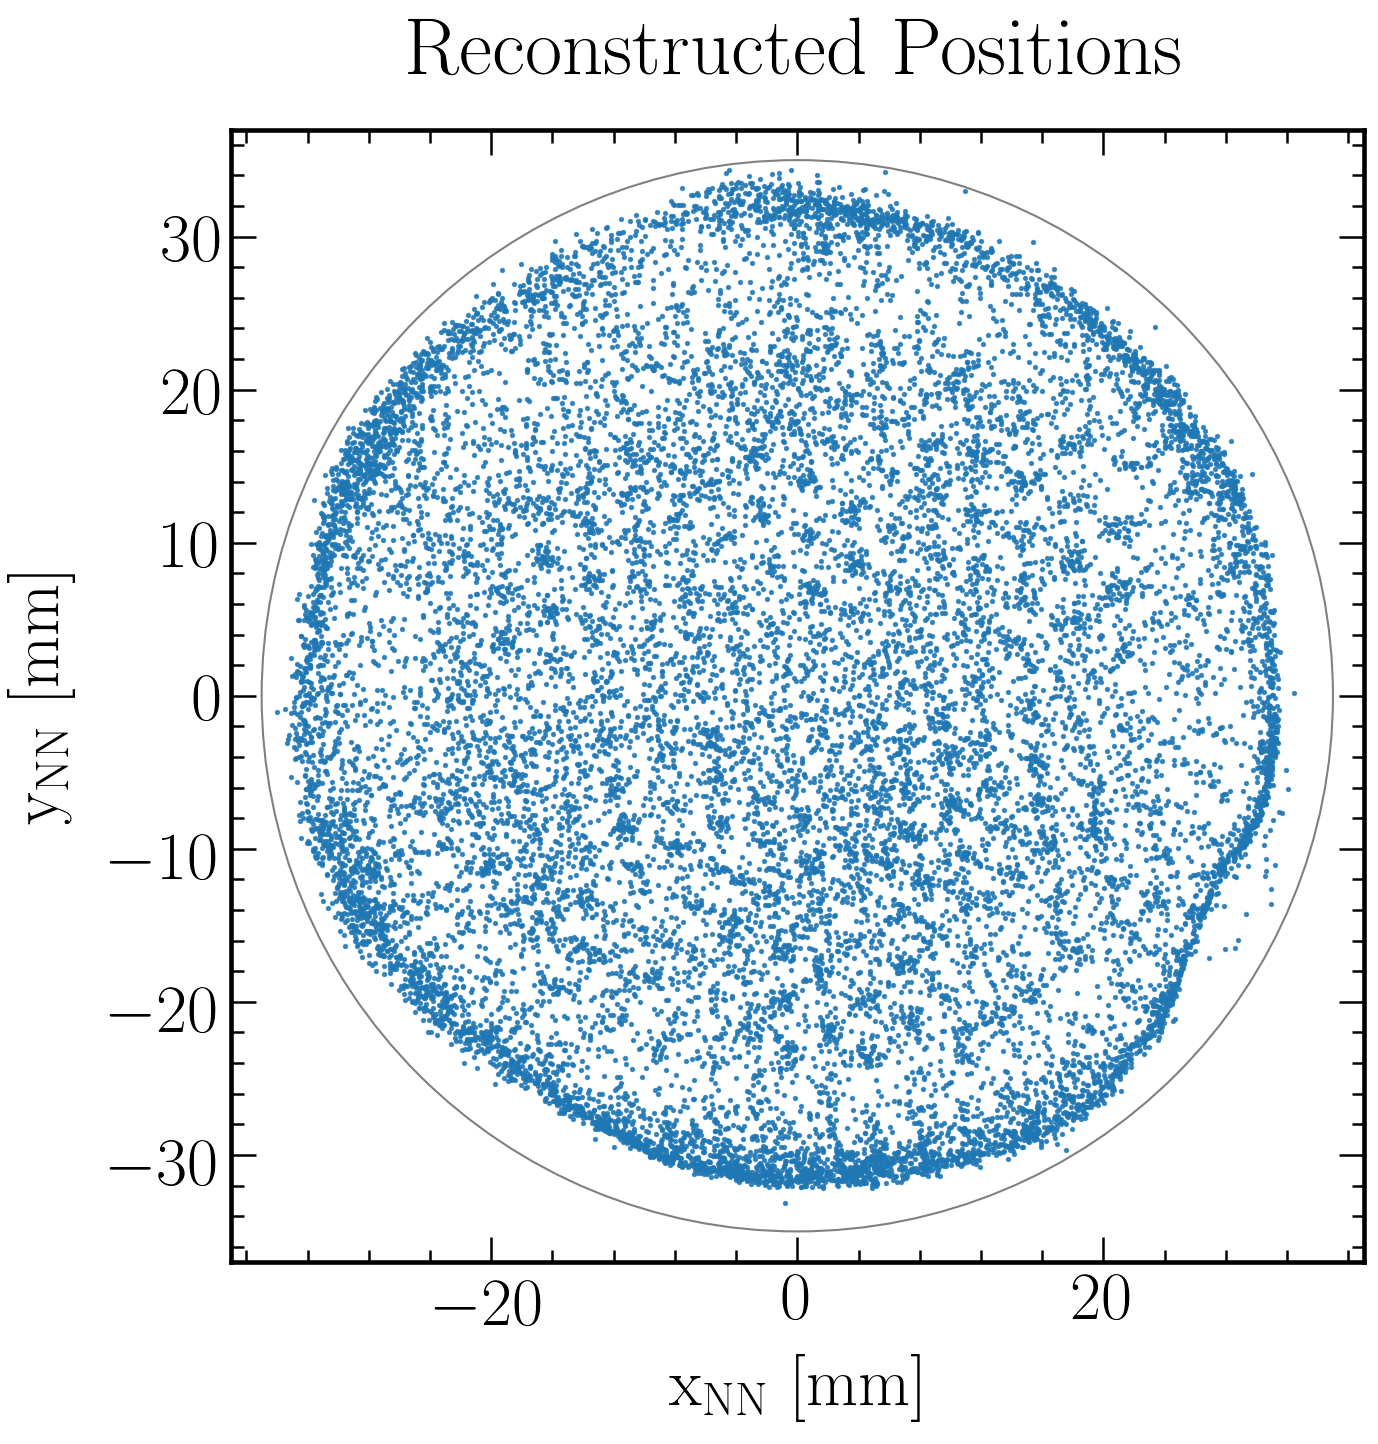

In [10]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
plt.scatter(predictions[:,0],
            predictions[:,1],
            marker='.',
            #s=1,
            s = 10,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-37,37)
plt.ylim(-37,37)

plt.xlabel('x$_\mathrm{NN}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{NN}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions', fontsize = title_size, pad = title_pad)

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_predictions_NN.png", bbox_inches = "tight")

## Evaluation

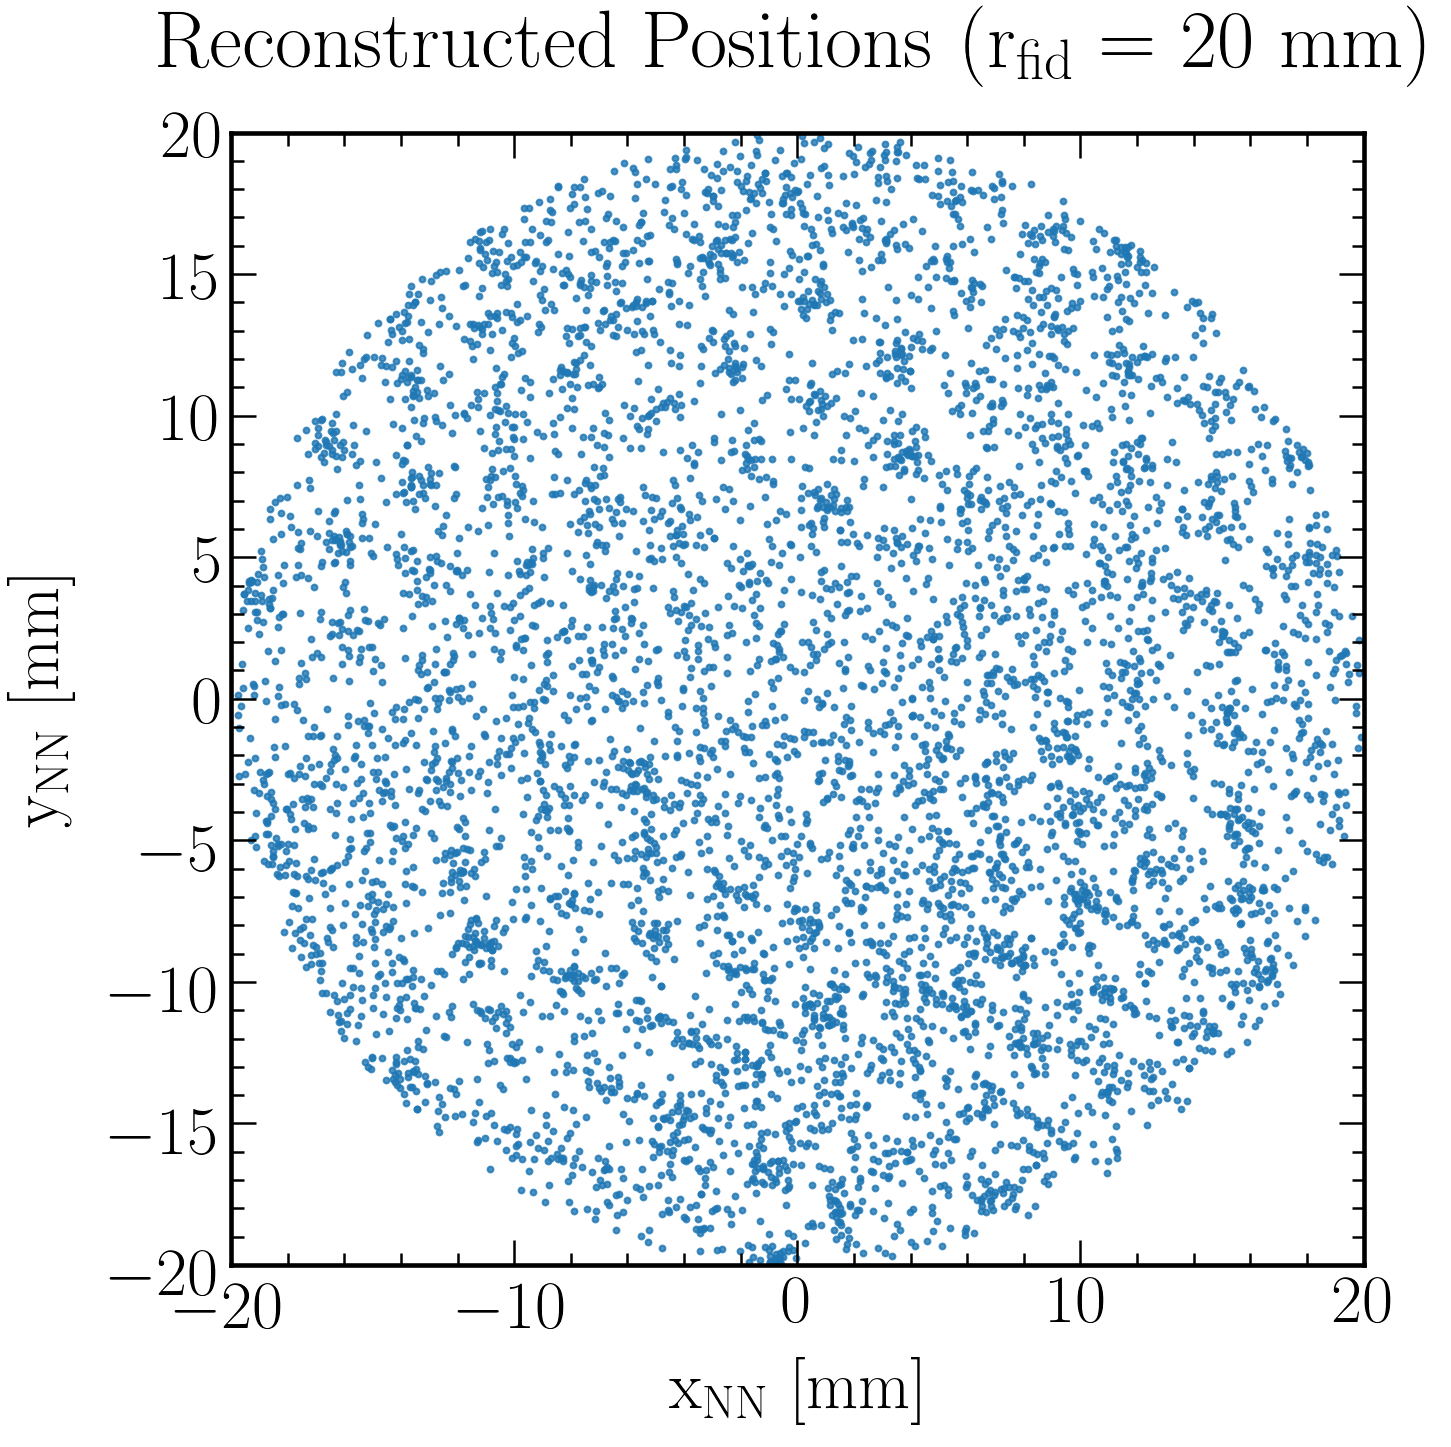

In [11]:
fig=plt.figure(figsize=(16, 10), dpi=150)

## Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Labels
label_size = 32.5
label_pad = 13
title_size = 39
title_pad = 26

## Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

## Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
## Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

## Data plot
r_fiducial = 20 # fiducial radius in mm
cut_fiducial = np.hypot(predictions[:,0], predictions[:,1])<r_fiducial

plt.scatter(predictions[:,0][cut_fiducial],
            predictions[:,1][cut_fiducial],
            marker='.',
            #s=1,
            s = 10*(35/r_fiducial)**2,
            ##c='k',
            alpha = 0.8,
           )

plt.xlim(-r_fiducial,r_fiducial)
plt.ylim(-r_fiducial,r_fiducial)

plt.xlabel('x$_\mathrm{NN}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('y$_\mathrm{NN}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.title('Reconstructed Positions (r$_\mathrm{fid}$ = '+str(r_fiducial)+' mm)', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

plt.show()
fig.savefig(filenameprefix+"_predictions_NN_fid_"+str(r_fiducial)+".png", bbox_inches = "tight")

pitch mesh = 3.00831 mm

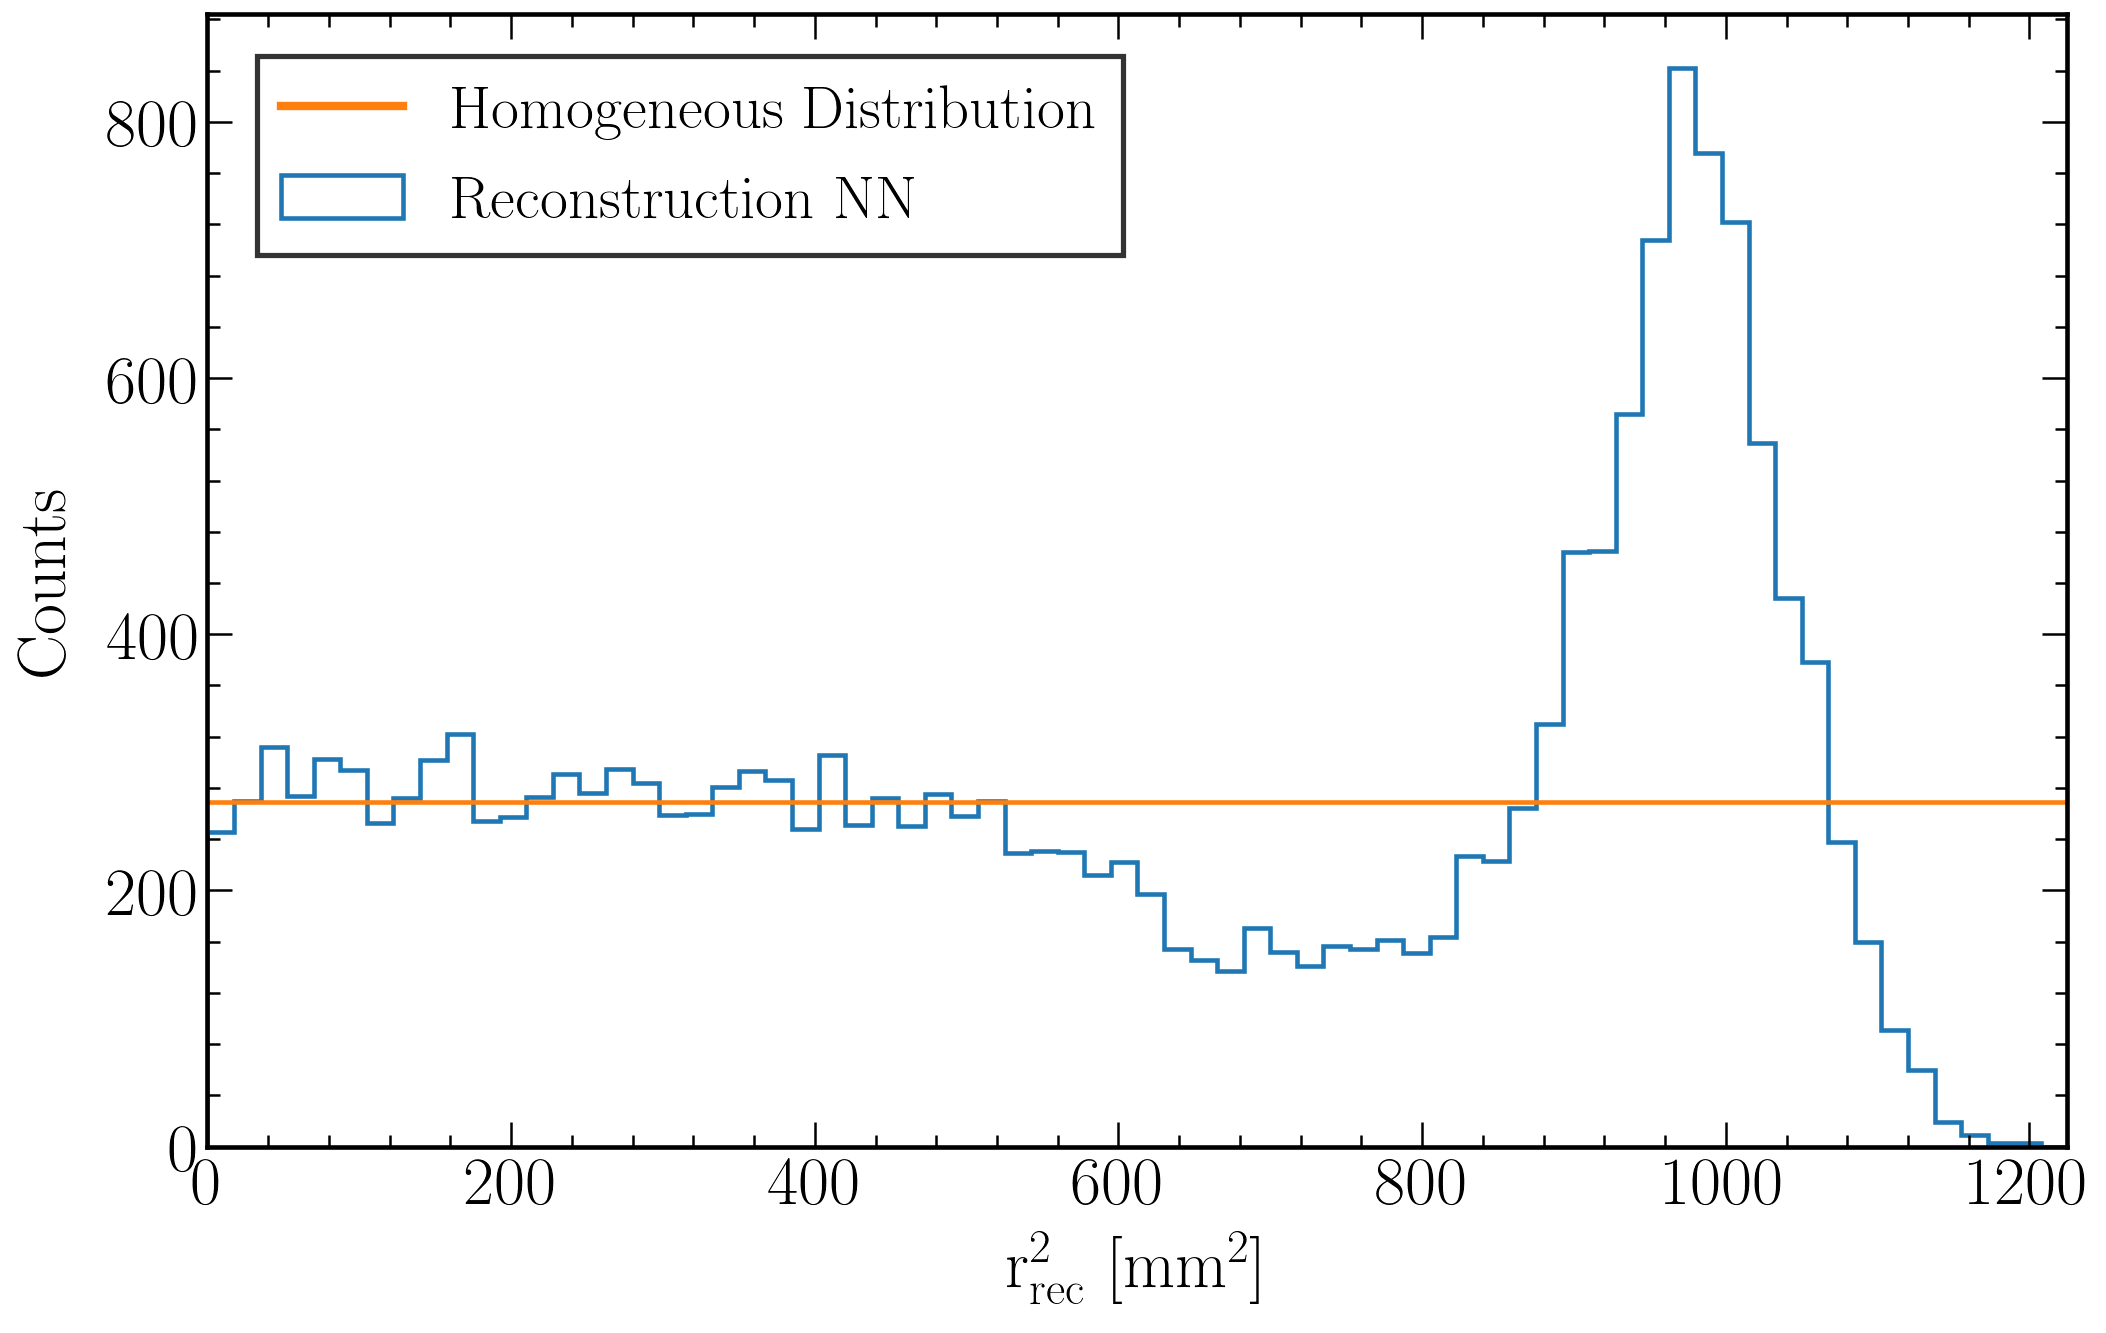

In [12]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.hist(np.hypot(predictions[:,0], predictions[:,1])**2, bins = bns, 
         range = (0,35**2), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction NN')
plt.plot([0, 35**2], [predictions.shape[0]/bns]*2, linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous Distribution')

plt.xlabel('r$_\mathrm{rec}^2$ [mm$^2$]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35**2)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_NN_r2spectrum.png")
plt.show()

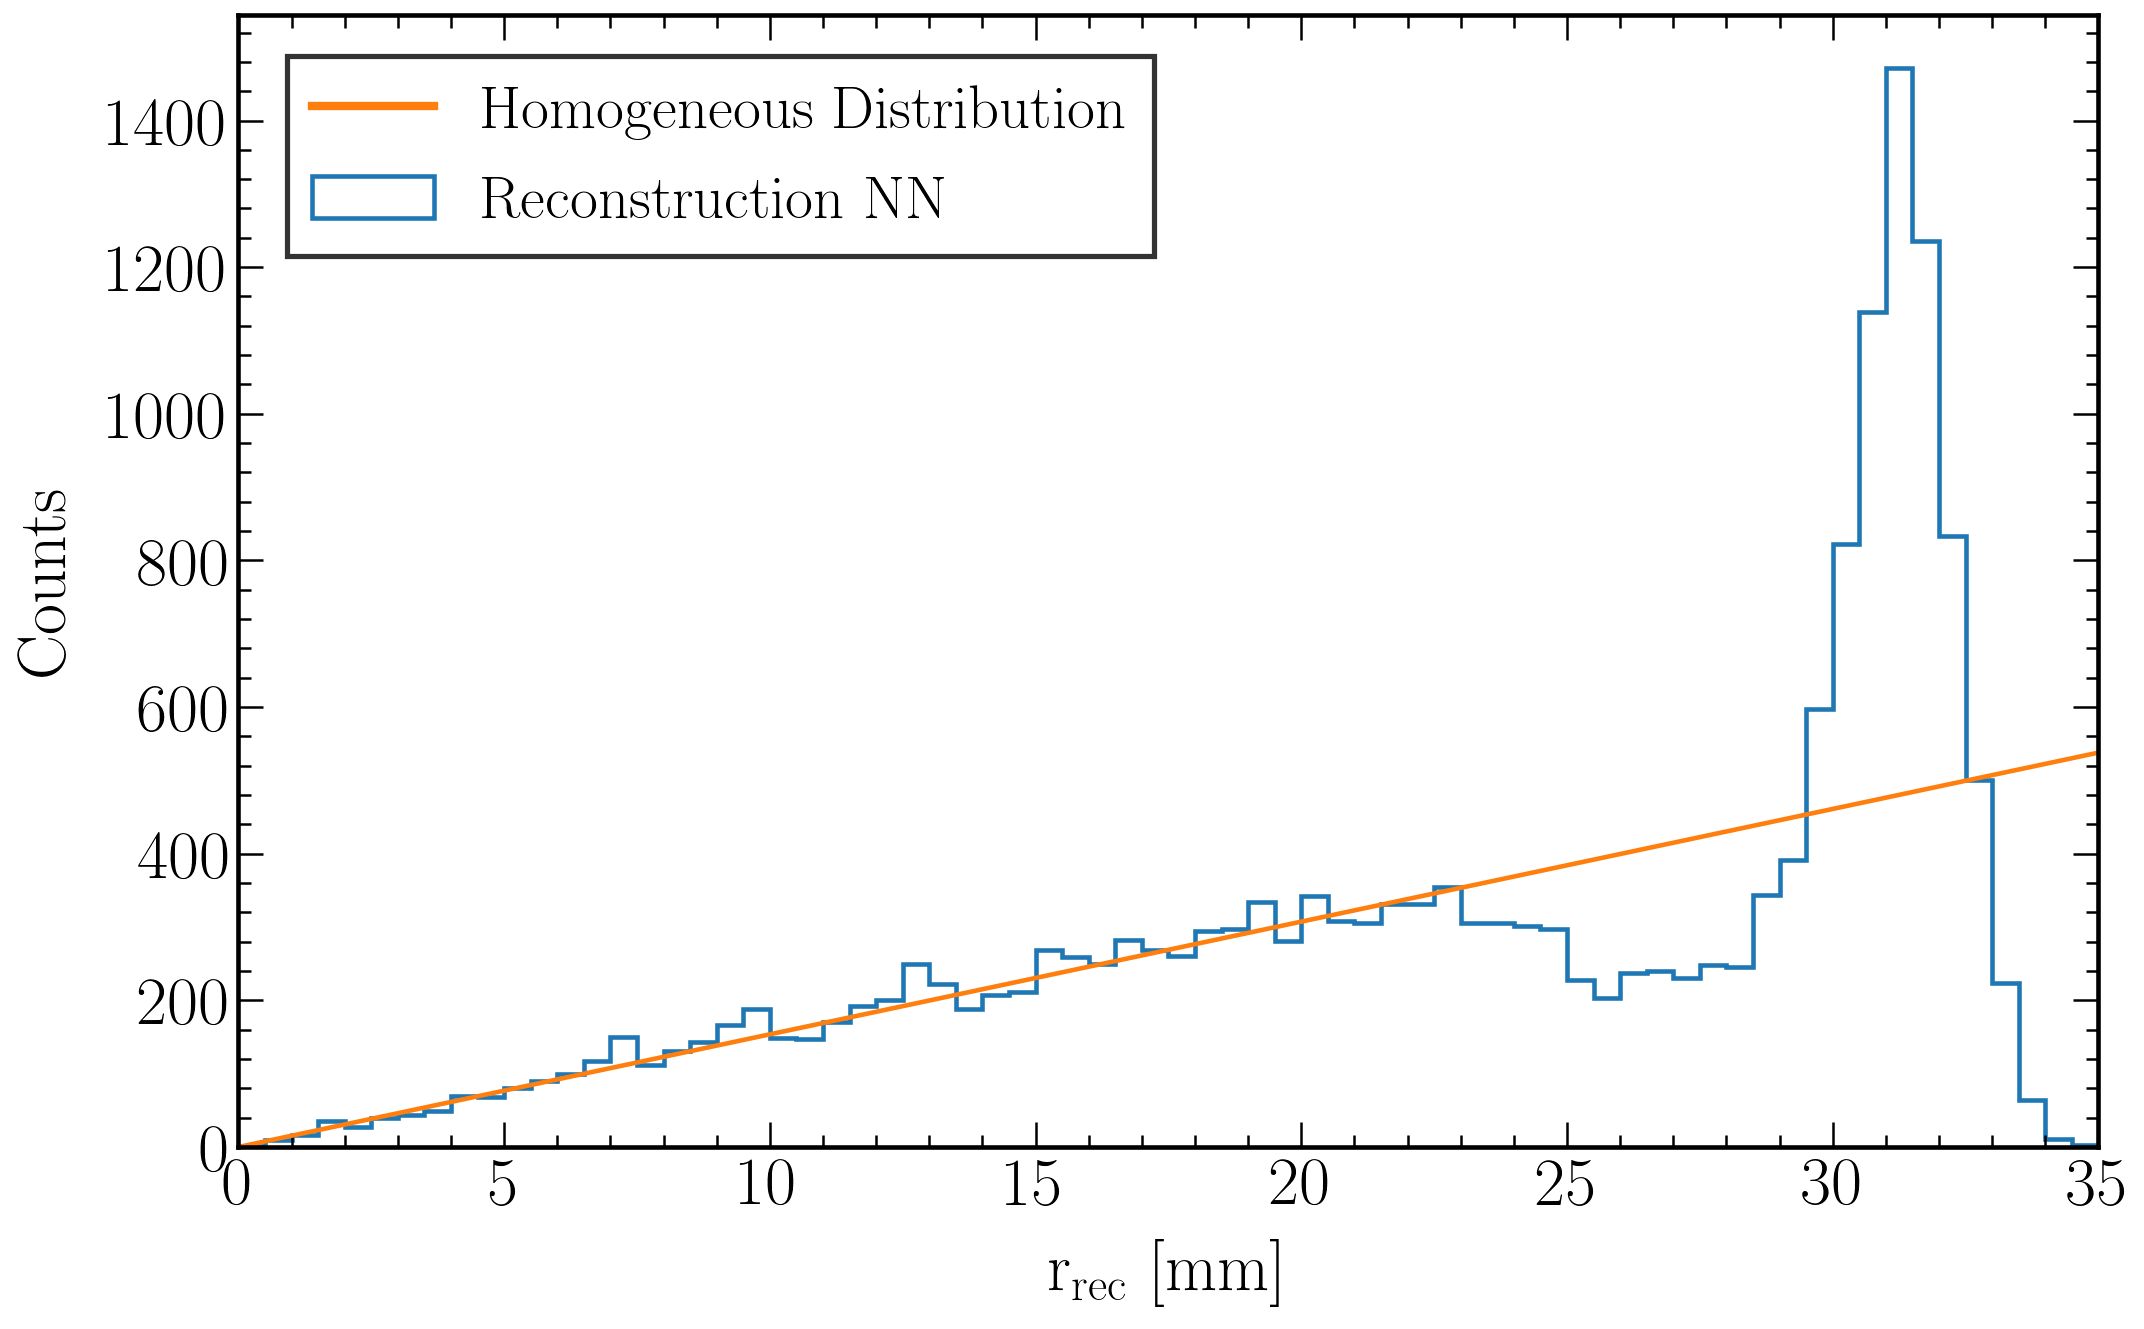

In [13]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 32.5 #25
label_pad = 13 #10
title_size = 39 #30
title_pad = 26 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
bns = 70

plt.hist(np.hypot(predictions[:,0], predictions[:,1]), bins = bns, 
         range = (0,35), density = False, histtype='step', linewidth = 2.2, 
         color = 'C0', label = 'Reconstruction NN')
plt.plot([0, 35], [0, bns/35*predictions.shape[0]/bns], linewidth = 2.2, color = 'C1', 
        label = 'Homogeneous Distribution')

plt.xlabel('r$_\mathrm{rec}$ [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)

plt.xlim(0, 35)
plt.ylim(bottom = 0)

# Legend
leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
#leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5)

fig.savefig(filenameprefix+"_predictions_NN_rspectrum.png")
plt.show()